In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import pickle 

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
#Reading the cleaned dataset done using fetchDataFromDB.py

BikesData = pd.read_csv("bikesDataCleaned.csv")
WeatherData= pd.read_csv("WeatherDataCleaned.csv")

In [3]:
BikesData.columns

Index(['address', 'available_bike_stands', 'available_bikes', 'banking',
       'bike_stands', 'bonus', 'contract_name', 'last_update', 'name',
       'number', 'position_lat', 'position_lng', 'status', 'DayOfWeek'],
      dtype='object')

In [4]:
WeatherData.columns

Index(['latitude', 'longitude', 'last_update', 'temperature', 'pressure',
       'wind_speed', 'humidity'],
      dtype='object')

In [5]:
BikesData.head()

,address,available_bike_stands,available_bikes,banking,bike_stands,bonus,contract_name,last_update,name,number,position_lat,position_lng,status,DayOfWeek
0,Smithfield North,2,28,1,30,0,dublin,2020-03-10 20:00:24,SMITHFIELD NORTH,42,53.35,-6.28,OPEN,Tuesday
1,Parnell Square North,20,0,1,20,0,dublin,2020-03-10 19:54:23,PARNELL SQUARE NORTH,30,53.35,-6.27,OPEN,Tuesday
2,Clonmel Street,33,0,0,33,0,dublin,2020-03-10 19:54:35,CLONMEL STREET,54,53.34,-6.26,OPEN,Tuesday
3,Avondale Road,24,16,0,40,0,dublin,2020-03-10 19:58:33,AVONDALE ROAD,108,53.36,-6.28,OPEN,Tuesday
4,Mount Street Lower,22,18,0,40,0,dublin,2020-03-10 19:58:54,MOUNT STREET LOWER,56,53.34,-6.24,OPEN,Tuesday


Dropping all the constant columns, Identification of the Bikes station will be done using 'number'

    'Name' same as 'address'
    'contract_name' - all Dublin
    'status' - all OPEN
    'bonus' - all 0

In [6]:
BikesData = BikesData.drop(columns=['name','contract_name','bonus','status'])

In [7]:
Categorical =["DayOfWeek","number",'address']
for _ in Categorical:
    BikesData[_] = BikesData[_].astype('category')

In [8]:
WeatherData["last_update"]=pd.to_datetime(WeatherData["last_update"])
BikesData["last_update"]=pd.to_datetime(BikesData["last_update"])

In [9]:
BikesData.last_update.min()

Timestamp('2020-03-10 19:50:50')

In [10]:
BikesData.last_update.max()

Timestamp('2020-03-28 19:52:12')

In [11]:
WeatherData.last_update.max()

Timestamp('2020-03-28 19:31:09')

In [12]:
WeatherData.last_update.min()

Timestamp('2020-03-10 20:32:55')

In [13]:
indexNames = WeatherData[WeatherData.last_update< '2020-03-10 19:30:00'].index

# Delete these row indexes from dataFrame when date of weather fetched is earlier than the day dublin bikes data fetched
WeatherData.drop(indexNames , inplace=True)

In [14]:
#Check the number of rows and columns in WeatherData
WeatherData.shape

(10669, 7)

Checking the bikes Availability on basis of temperature

In [15]:
WeatherData = WeatherData.drop(columns=['pressure','humidity','wind_speed'])

After cleaning, printing the head of both dataframes

In [16]:
BikesData.head(3)

,address,available_bike_stands,available_bikes,banking,bike_stands,last_update,number,position_lat,position_lng,DayOfWeek
0,Smithfield North,2,28,1,30,2020-03-10 20:00:24,42,53.35,-6.28,Tuesday
1,Parnell Square North,20,0,1,20,2020-03-10 19:54:23,30,53.35,-6.27,Tuesday
2,Clonmel Street,33,0,0,33,2020-03-10 19:54:35,54,53.34,-6.26,Tuesday


In [17]:
WeatherData.head(3)

,latitude,longitude,last_update,temperature
0,53.34,-6.25,2020-03-10 20:46:02,5.98
1,53.34,-6.24,2020-03-10 20:46:02,5.98
2,53.34,-6.28,2020-03-10 20:46:02,5.98


In [18]:
#Since we need all numeric features to predict, Hot-encoding the 'DayOfWeek' in BikesData

BikesData_encoded = pd.get_dummies(BikesData, prefix_sep=".",columns=['DayOfWeek'])

In [19]:
#All the bike station numbers
BikesData_number = list(BikesData_encoded.number.unique())
BikesData_number.sort()

In [20]:
#Number of Stations

len(BikesData_number)

110

In [21]:
#Checking if there is any null value in any of columns

BikesData_encoded.isnull().sum()

address                  0
available_bike_stands    0
available_bikes          0
banking                  0
bike_stands              0
last_update              0
number                   0
position_lat             0
position_lng             0
DayOfWeek.Friday         0
DayOfWeek.Monday         0
DayOfWeek.Saturday       0
DayOfWeek.Sunday         0
DayOfWeek.Thursday       0
DayOfWeek.Tuesday        0
DayOfWeek.Wednesday      0
dtype: int64

Below function is merging the BikesData rows(corresponding to a particular station number) with the temperature grouping by latitude and longitude

#### Requires the station number

In [22]:
def mergeBikesAndWeather(stationNumber):
    BikesData1 = BikesData_encoded[(BikesData_encoded.number==stationNumber)]
    df = BikesData1.merge(WeatherData,\
                        left_on=['position_lat','position_lng'], \
                        right_on=['latitude','longitude'], \
                        how='left')
    df = df.drop(df[(abs(df.last_update_x-df.last_update_y)/np.timedelta64(1,'D')>=0.020)].index)

    df = df.T.drop_duplicates().T
    df = df.drop(columns=["position_lat","position_lng",'last_update_y'])
    return df.reset_index(drop=True)

#### Below function converts to appropriate data types

In [23]:
def ConvertDataTypes(df):
    
    #Floating point
    Float = ['temperature']
    for _ in Float:
        df[_] = df[_].astype('float')
    
    #All numeric values
    Integers = ['available_bike_stands','available_bikes','banking','bike_stands','number']
    for _ in Integers:
        df[_] = df[_].astype('int64')
    
    #Since we created a new DF, returned datatype after hot encoding the DayOfWeek got lost
    DaysofWeek = ['DayOfWeek.Friday','DayOfWeek.Monday','DayOfWeek.Saturday','DayOfWeek.Sunday',\
                  'DayOfWeek.Thursday','DayOfWeek.Tuesday','DayOfWeek.Wednesday']
    for _ in DaysofWeek:
        df[_] = df[_].astype('uint8')
        
    return df

#### Below function will remove the date from the datetime object and return the hour 

For e.g., 2020-03-10 20:00:24 will return 20

In [24]:
def extractHour(date):
    return date.hour

In [25]:
df = pd.DataFrame()
for bikeStationNumber in BikesData_number:
    df_stationNumber = mergeBikesAndWeather(bikeStationNumber)
    df = df.append(df_stationNumber)

C:\Users\deepak sharma\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


After the tables for merged, For address 'Ormond Quay Upper', station number was getting lost and station number was returning NAN

Tried a lot to figure out the reason, but couldn't find hence did below step.

In [26]:
df.loc[df.address == "Ormond Quay Upper", "number"] = 29

Printing the new merged dataframe

In [27]:
df.head()

,DayOfWeek.Friday,DayOfWeek.Monday,DayOfWeek.Saturday,DayOfWeek.Sunday,DayOfWeek.Thursday,DayOfWeek.Tuesday,DayOfWeek.Wednesday,address,available_bike_stands,available_bikes,banking,bike_stands,last_update_x,number,temperature
0,0,0,0,0,0,1,0,Blessington Street,16,4,1,20,2020-03-10 20:17:51,2,6.27
1,0,0,0,0,0,1,0,Blessington Street,15,5,1,20,2020-03-10 20:26:50,2,6.27
2,0,0,0,0,0,1,0,Blessington Street,14,6,1,20,2020-03-10 20:36:21,2,6.27
3,0,0,0,0,0,1,0,Blessington Street,14,6,1,20,2020-03-10 20:46:29,2,6.27
4,0,0,0,0,0,1,0,Blessington Street,14,6,1,20,2020-03-10 20:54:21,2,6.27


In [28]:
#Convert to appropriate datatypes
ConvertDataTypes(df)

#Converting to hour
df["last_update_x"] = df["last_update_x"].apply(extractHour)

df = df.rename(columns={"last_update_x": "Hour"})
df["Hour"] = df["Hour"].astype('int64')

In [29]:
#Converting the 24 hour format to 12 hour one
df["AM/PM"] = np.where(df['Hour']>12, 'PM', 'AM')

df["Hour"] = np.where(df['Hour']>12, abs(12-df['Hour']), df['Hour'])

df = pd.get_dummies(df, prefix_sep=".",columns=['AM/PM'])

In [30]:
df.columns

Index(['DayOfWeek.Friday', 'DayOfWeek.Monday', 'DayOfWeek.Saturday',
       'DayOfWeek.Sunday', 'DayOfWeek.Thursday', 'DayOfWeek.Tuesday',
       'DayOfWeek.Wednesday', 'address', 'available_bike_stands',
       'available_bikes', 'banking', 'bike_stands', 'Hour', 'number',
       'temperature', 'AM/PM.AM', 'AM/PM.PM'],
      dtype='object')

Reordering the columns

In [31]:
df_new = df[['available_bike_stands','available_bikes','banking','bike_stands', 'Hour','AM/PM.AM', 'AM/PM.PM','number', 'temperature',\
         'DayOfWeek.Monday','DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
         'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']]

In [32]:
df_new.head()

,available_bike_stands,available_bikes,banking,bike_stands,Hour,AM/PM.AM,AM/PM.PM,number,temperature,DayOfWeek.Monday,DayOfWeek.Tuesday,DayOfWeek.Wednesday,DayOfWeek.Thursday,DayOfWeek.Friday,DayOfWeek.Saturday,DayOfWeek.Sunday
0,16,4,1,20,8,0,1,2,6.27,0,1,0,0,0,0,0
1,15,5,1,20,8,0,1,2,6.27,0,1,0,0,0,0,0
2,14,6,1,20,8,0,1,2,6.27,0,1,0,0,0,0,0
3,14,6,1,20,8,0,1,2,6.27,0,1,0,0,0,0,0
4,14,6,1,20,8,0,1,2,6.27,0,1,0,0,0,0,0


In [33]:
df_new.isnull().sum()

available_bike_stands    0
available_bikes          0
banking                  0
bike_stands              0
Hour                     0
AM/PM.AM                 0
AM/PM.PM                 0
number                   0
temperature              0
DayOfWeek.Monday         0
DayOfWeek.Tuesday        0
DayOfWeek.Wednesday      0
DayOfWeek.Thursday       0
DayOfWeek.Friday         0
DayOfWeek.Saturday       0
DayOfWeek.Sunday         0
dtype: int64

In [34]:
df_new.shape

(312958, 16)

In [35]:
df_new.to_csv('mergedBikesAndWeather.csv',index=False)

In [36]:
df_new.dtypes

available_bike_stands      int64
available_bikes            int64
banking                    int64
bike_stands                int64
Hour                       int64
AM/PM.AM                   uint8
AM/PM.PM                   uint8
number                     int64
temperature              float64
DayOfWeek.Monday           uint8
DayOfWeek.Tuesday          uint8
DayOfWeek.Wednesday        uint8
DayOfWeek.Thursday         uint8
DayOfWeek.Friday           uint8
DayOfWeek.Saturday         uint8
DayOfWeek.Sunday           uint8
dtype: object

In [37]:
df_new.available_bikes.mean()

12.0047098971747

In [38]:
cont_features = ['Hour','AM/PM.AM', 'AM/PM.PM','temperature','available_bike_stands','DayOfWeek.Monday',\
                 'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                 'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']

convert floating point pressure and wind_speed to int

In [39]:
df_new[cont_features].corr()

,Hour,AM/PM.AM,AM/PM.PM,temperature,available_bike_stands,DayOfWeek.Monday,DayOfWeek.Tuesday,DayOfWeek.Wednesday,DayOfWeek.Thursday,DayOfWeek.Friday,DayOfWeek.Saturday,DayOfWeek.Sunday
Hour,1.000000,0.075452,-0.075452,0.012746,-0.004592,-0.034080,0.067991,0.001903,0.003127,-0.002579,-0.026796,-0.007854
AM/PM.AM,0.075452,1.000000,-1.000000,-0.317513,-0.000081,0.006161,-0.066185,0.006997,0.001452,0.005043,0.035911,0.002136
AM/PM.PM,-0.075452,-1.000000,1.000000,0.317513,0.000081,-0.006161,0.066185,-0.006997,-0.001452,-0.005043,-0.035911,-0.002136
temperature,0.012746,-0.317513,0.317513,1.000000,0.001575,0.060504,0.351347,0.101013,-0.246752,-0.128392,0.040111,-0.119109
available_bike_stands,-0.004592,-0.000081,0.000081,0.001575,1.000000,-0.000030,0.002550,0.000572,-0.002690,0.001511,-0.004494,0.003416
DayOfWeek.Monday,-0.034080,0.006161,-0.006161,0.060504,-0.000030,1.000000,-0.112873,-0.149752,-0.149171,-0.149056,-0.138479,-0.114027
DayOfWeek.Tuesday,0.067991,-0.066185,0.066185,0.351347,0.002550,-0.112873,1.000000,-0.162575,-0.161944,-0.161819,-0.150337,-0.123791
DayOfWeek.Wednesday,0.001903,0.006997,-0.006997,0.101013,0.000572,-0.149752,-0.162575,1.000000,-0.214856,-0.214690,-0.199456,-0.164236
DayOfWeek.Thursday,0.003127,0.001452,-0.001452,-0.246752,-0.002690,-0.149171,-0.161944,-0.214856,1.000000,-0.213858,-0.198682,-0.163600
DayOfWeek.Friday,-0.002579,0.005043,-0.005043,-0.128392,0.001511,-0.149056,-0.161819,-0.214690,-0.213858,1.000000,-0.198529,-0.163474


## Predicting the bikes availability using Random Forest (using more than one feature)

Why Random Forest?

- the features we have, are all independent from each other(like temperature vs hour hence, this model is adequate
   
### Training the model

# Evaluation with train/test split

In [40]:
# Split the data into train and test sets
# Take a third (random) data samples as test data, rest as training data
# If we want to get the same train/test split every time we run, we can set the random_state variable to a fixed value

def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    #need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
    #Training Data reset index
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    
    # Testing Data reset index
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    return X_train, X_test, y_train, y_test

#### Print out the coefficients learned by the model

In [41]:
def Prediction(X_train, X_test, y_train, y_test):
    #Prediction on Trainig  set 
    #model = LinearRegression()
    
    rfc = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
    
    rfc.fit(X_train,y_train)
    
    importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
    print(importance.sort_values('importance', ascending=False))
    
    #Prediction on Train Data

    rfc_predictions_train = rfc.predict(X_train)
    df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
    print(df_true_vs_rfc_predicted.head(20))
    
    #Prediction on test Data
    rfc_predictions_test = rfc.predict(X_test)
    df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
    df_true_vs_rfc_predicted_test.head(20)
    
    print("\nrfc.oob_score_",rfc.oob_score_,"\n")
    return rfc

Printing Actual available_bikes vs predicted based on test data

In [44]:
def bikeAvailability():
    for _ in BikesData_number:
        df_new = df[df.number==_]
        X = df_new[cont_features]
        y = df_new.available_bikes
        
        print("\n~~~~~~ STATION NUMBER =",_,"~~~~~~\n")
        X_train, X_test, y_train, y_test = train_test(X,y)
       
        rfc = Prediction(X_train, X_test, y_train, y_test)
        
        with open('./PickelFiles/'+str(_)+'.pkl','wb') as write:
            pickle.dump(rfc,write)
    
    return

In [45]:
bikeAvailability()


~~~~~~ STATION NUMBER = 2 ~~~~~~

                  feature  importance
4   available_bike_stands         1.0
0                    Hour         0.0
1                AM/PM.AM         0.0
2                AM/PM.PM         0.0
3             temperature         0.0
5        DayOfWeek.Monday         0.0
6       DayOfWeek.Tuesday         0.0
7     DayOfWeek.Wednesday         0.0
8      DayOfWeek.Thursday         0.0
9        DayOfWeek.Friday         0.0
10     DayOfWeek.Saturday         0.0
11       DayOfWeek.Sunday         0.0
    ActualClass  PredictedClass
0            12            12.0
1             5             5.0
2            11            11.0
3            17            17.0
4            14            14.0
5            17            17.0
6            14            14.0
7             0             0.0
8            15            15.0
9            19            19.0
10           18            18.0
11           13            13.0
12            6             6.0
13            4        

                  feature  importance
4   available_bike_stands    0.998799
3             temperature    0.000404
0                    Hour    0.000344
9        DayOfWeek.Friday    0.000114
7     DayOfWeek.Wednesday    0.000113
10     DayOfWeek.Saturday    0.000080
1                AM/PM.AM    0.000047
2                AM/PM.PM    0.000046
8      DayOfWeek.Thursday    0.000031
11       DayOfWeek.Sunday    0.000011
5        DayOfWeek.Monday    0.000010
6       DayOfWeek.Tuesday    0.000001
    ActualClass  PredictedClass
0             6            6.00
1             0            0.00
2             7            7.00
3             2            2.00
4             4            3.95
5            24           23.99
6             6            6.00
7             4            4.00
8             8            8.00
9             4            4.00
10           22           22.00
11            3            3.00
12            8            8.00
13            4            4.00
14            4           

                  feature    importance
4   available_bike_stands  9.985431e-01
3             temperature  5.545296e-04
8      DayOfWeek.Thursday  2.691524e-04
0                    Hour  2.621872e-04
7     DayOfWeek.Wednesday  1.300742e-04
1                AM/PM.AM  1.185615e-04
2                AM/PM.PM  1.174917e-04
10     DayOfWeek.Saturday  2.529768e-06
5        DayOfWeek.Monday  2.059498e-06
9        DayOfWeek.Friday  2.680158e-07
6       DayOfWeek.Tuesday  0.000000e+00
11       DayOfWeek.Sunday  0.000000e+00
    ActualClass  PredictedClass
0            13           13.00
1            12           12.00
2             2            2.00
3             2            2.00
4             8            8.00
5             6            6.00
6             6            6.00
7            17           17.00
8            13           13.00
9             9            9.00
10            9            9.00
11            0            0.04
12            6            6.00
13            6            6.00


                  feature    importance
4   available_bike_stands  9.990243e-01
3             temperature  3.723286e-04
0                    Hour  2.194237e-04
9        DayOfWeek.Friday  9.752111e-05
8      DayOfWeek.Thursday  8.472435e-05
2                AM/PM.PM  7.815807e-05
1                AM/PM.AM  7.254568e-05
5        DayOfWeek.Monday  3.809324e-05
7     DayOfWeek.Wednesday  6.721685e-06
10     DayOfWeek.Saturday  6.111784e-06
6       DayOfWeek.Tuesday  1.207896e-07
11       DayOfWeek.Sunday  0.000000e+00
    ActualClass  PredictedClass
0             8             8.0
1             6             6.0
2             5             5.0
3             7             7.0
4             0             0.0
5             7             7.0
6             9             9.0
7             7             7.0
8             8             8.0
9             7             7.0
10           16            16.0
11            0             0.0
12            4             4.0
13            4             4.0


                  feature  importance
4   available_bike_stands    0.996469
3             temperature    0.000973
0                    Hour    0.000863
5        DayOfWeek.Monday    0.000806
7     DayOfWeek.Wednesday    0.000518
1                AM/PM.AM    0.000130
2                AM/PM.PM    0.000110
9        DayOfWeek.Friday    0.000103
8      DayOfWeek.Thursday    0.000017
11       DayOfWeek.Sunday    0.000008
6       DayOfWeek.Tuesday    0.000003
10     DayOfWeek.Saturday    0.000000
    ActualClass  PredictedClass
0            10           10.00
1            10           10.00
2            16           16.00
3            14           14.00
4             9            9.00
5             3            3.00
6             7            7.00
7             4            4.00
8            18           18.00
9            12           12.00
10           20           20.02
11            9            9.00
12           11           11.00
13            3            3.00
14            8           

                  feature    importance
4   available_bike_stands  9.996158e-01
3             temperature  1.674479e-04
0                    Hour  1.234865e-04
7     DayOfWeek.Wednesday  3.379736e-05
8      DayOfWeek.Thursday  1.931145e-05
1                AM/PM.AM  1.326450e-05
9        DayOfWeek.Friday  8.710961e-06
2                AM/PM.PM  7.740152e-06
11       DayOfWeek.Sunday  6.537056e-06
10     DayOfWeek.Saturday  3.244724e-06
5        DayOfWeek.Monday  6.945287e-07
6       DayOfWeek.Tuesday  0.000000e+00
    ActualClass  PredictedClass
0            15           15.00
1            20           20.00
2             4            4.00
3            21           21.00
4            18           18.00
5             4            4.00
6            11           11.00
7             8            8.00
8             7            7.00
9            12           12.00
10           11           10.96
11            0            0.00
12           12           12.00
13           10           10.00


                  feature    importance
4   available_bike_stands  9.992286e-01
3             temperature  4.179912e-04
0                    Hour  1.334705e-04
7     DayOfWeek.Wednesday  1.091733e-04
10     DayOfWeek.Saturday  5.855031e-05
1                AM/PM.AM  2.030422e-05
2                AM/PM.PM  1.944553e-05
5        DayOfWeek.Monday  7.244658e-06
9        DayOfWeek.Friday  2.043686e-06
8      DayOfWeek.Thursday  1.299396e-06
6       DayOfWeek.Tuesday  1.087988e-06
11       DayOfWeek.Sunday  7.710240e-07
    ActualClass  PredictedClass
0            38           38.01
1            21           21.00
2             6            6.00
3             3            3.00
4             9            9.38
5            37           37.00
6             3            3.00
7            11           11.00
8             1            1.00
9            16           16.00
10           19           19.00
11            4            4.00
12            4            4.00
13           23           23.00


                  feature    importance
4   available_bike_stands  9.999870e-01
0                    Hour  8.191803e-06
3             temperature  2.225362e-06
8      DayOfWeek.Thursday  1.585020e-06
7     DayOfWeek.Wednesday  6.691484e-07
2                AM/PM.PM  2.556982e-07
1                AM/PM.AM  1.044602e-07
5        DayOfWeek.Monday  0.000000e+00
6       DayOfWeek.Tuesday  0.000000e+00
9        DayOfWeek.Friday  0.000000e+00
10     DayOfWeek.Saturday  0.000000e+00
11       DayOfWeek.Sunday  0.000000e+00
    ActualClass  PredictedClass
0            11            11.0
1            22            22.0
2             1             1.0
3             3             3.0
4             4             4.0
5             3             3.0
6             6             6.0
7            10            10.0
8             3             3.0
9             5             5.0
10           10            10.0
11           18            18.0
12            4             4.0
13           10            10.0


                  feature    importance
4   available_bike_stands  9.991709e-01
3             temperature  2.486332e-04
7     DayOfWeek.Wednesday  1.605575e-04
0                    Hour  1.491958e-04
2                AM/PM.PM  1.066788e-04
1                AM/PM.AM  9.622791e-05
9        DayOfWeek.Friday  6.439283e-05
8      DayOfWeek.Thursday  3.181016e-06
10     DayOfWeek.Saturday  2.031662e-07
5        DayOfWeek.Monday  0.000000e+00
6       DayOfWeek.Tuesday  0.000000e+00
11       DayOfWeek.Sunday  0.000000e+00
    ActualClass  PredictedClass
0             8           8.000
1            10          10.000
2             9           9.000
3             9           9.000
4            22          21.990
5            11          11.000
6            14          14.000
7             5           5.000
8             9           8.995
9            10          10.000
10            9           9.000
11           13          13.000
12            8           8.000
13           10          10.000


                  feature    importance
4   available_bike_stands  9.980496e-01
3             temperature  1.050014e-03
0                    Hour  2.907202e-04
5        DayOfWeek.Monday  1.642892e-04
2                AM/PM.PM  1.349909e-04
1                AM/PM.AM  1.065291e-04
7     DayOfWeek.Wednesday  7.834431e-05
10     DayOfWeek.Saturday  7.316898e-05
9        DayOfWeek.Friday  3.632896e-05
8      DayOfWeek.Thursday  1.290694e-05
6       DayOfWeek.Tuesday  2.747267e-06
11       DayOfWeek.Sunday  3.668486e-07
    ActualClass  PredictedClass
0            17           17.00
1            25           25.00
2            10           10.00
3            18           18.00
4            10           10.00
5             1            1.00
6            10           10.00
7             5            5.07
8             3            3.00
9             1            1.00
10            2            2.00
11            5            5.00
12            8            7.88
13           10           10.00


                  feature    importance
4   available_bike_stands  9.997043e-01
5        DayOfWeek.Monday  1.122710e-04
0                    Hour  7.777014e-05
3             temperature  6.015101e-05
11       DayOfWeek.Sunday  1.901641e-05
2                AM/PM.PM  1.446930e-05
1                AM/PM.AM  1.132636e-05
10     DayOfWeek.Saturday  3.351626e-07
7     DayOfWeek.Wednesday  2.740136e-07
9        DayOfWeek.Friday  8.687345e-08
6       DayOfWeek.Tuesday  0.000000e+00
8      DayOfWeek.Thursday  0.000000e+00
    ActualClass  PredictedClass
0            26            26.0
1            25            25.0
2             2             2.0
3            25            25.0
4            33            32.9
5            21            21.0
6            34            34.0
7            32            32.0
8            26            26.0
9            12            12.0
10           18            18.0
11           17            17.0
12           11            11.0
13           20            20.0


                  feature    importance
4   available_bike_stands  9.991887e-01
3             temperature  2.403905e-04
7     DayOfWeek.Wednesday  1.932172e-04
0                    Hour  1.694504e-04
9        DayOfWeek.Friday  8.976947e-05
1                AM/PM.AM  4.429128e-05
2                AM/PM.PM  4.231333e-05
6       DayOfWeek.Tuesday  2.272291e-05
5        DayOfWeek.Monday  6.062710e-06
10     DayOfWeek.Saturday  3.103696e-06
8      DayOfWeek.Thursday  7.738589e-09
11       DayOfWeek.Sunday  0.000000e+00
    ActualClass  PredictedClass
0            26            26.0
1             2             2.0
2             0             0.0
3             4             4.0
4             2             2.0
5            14            14.0
6            14            14.0
7            18            18.0
8            16            16.0
9            24            24.0
10            1             1.0
11           24            24.0
12            6             6.0
13           21            21.0


                  feature    importance
4   available_bike_stands  9.994249e-01
5        DayOfWeek.Monday  3.709708e-04
3             temperature  1.464212e-04
0                    Hour  4.814843e-05
1                AM/PM.AM  5.260311e-06
2                AM/PM.PM  2.028723e-06
10     DayOfWeek.Saturday  1.076005e-06
6       DayOfWeek.Tuesday  3.246736e-07
8      DayOfWeek.Thursday  3.051905e-07
7     DayOfWeek.Wednesday  2.976507e-07
9        DayOfWeek.Friday  2.827451e-07
11       DayOfWeek.Sunday  0.000000e+00
    ActualClass  PredictedClass
0            24       24.000000
1            31       31.000000
2            26       26.000000
3            17       18.094333
4            22       22.000000
5            38       38.000000
6            26       26.000000
7            14       14.000000
8            32       32.000000
9            37       37.000000
10           25       25.000000
11           13       13.000000
12           31       31.000000
13           15       15.000000


                  feature  importance
4   available_bike_stands    0.999207
3             temperature    0.000351
0                    Hour    0.000161
7     DayOfWeek.Wednesday    0.000096
9        DayOfWeek.Friday    0.000067
2                AM/PM.PM    0.000039
1                AM/PM.AM    0.000037
8      DayOfWeek.Thursday    0.000035
6       DayOfWeek.Tuesday    0.000006
5        DayOfWeek.Monday    0.000001
10     DayOfWeek.Saturday    0.000000
11       DayOfWeek.Sunday    0.000000
    ActualClass  PredictedClass
0             2            2.00
1             3            3.00
2             3            3.00
3            21           21.00
4             6            6.00
5             3            3.00
6             1            1.00
7             2            2.00
8             6            6.00
9             3            3.00
10            3            3.00
11            3            3.00
12            3            3.00
13            7            7.00
14            6           

                  feature    importance
4   available_bike_stands  9.890976e-01
7     DayOfWeek.Wednesday  1.032483e-02
3             temperature  2.587789e-04
0                    Hour  1.419050e-04
6       DayOfWeek.Tuesday  6.840433e-05
5        DayOfWeek.Monday  5.195789e-05
1                AM/PM.AM  2.275293e-05
2                AM/PM.PM  2.160482e-05
8      DayOfWeek.Thursday  5.783295e-06
9        DayOfWeek.Friday  5.152240e-06
10     DayOfWeek.Saturday  8.983616e-07
11       DayOfWeek.Sunday  3.354626e-07
    ActualClass  PredictedClass
0            15           15.00
1            14           14.00
2            23           23.00
3            24           24.00
4            20           20.00
5            16           16.00
6            16           16.00
7             6            6.00
8            15           15.00
9            19           19.00
10           15           15.00
11           13           13.45
12           11           11.00
13           10           10.00


                  feature  importance
4   available_bike_stands    0.999458
0                    Hour    0.000175
3             temperature    0.000149
8      DayOfWeek.Thursday    0.000086
7     DayOfWeek.Wednesday    0.000049
2                AM/PM.PM    0.000044
1                AM/PM.AM    0.000037
9        DayOfWeek.Friday    0.000002
5        DayOfWeek.Monday    0.000000
6       DayOfWeek.Tuesday    0.000000
10     DayOfWeek.Saturday    0.000000
11       DayOfWeek.Sunday    0.000000
    ActualClass  PredictedClass
0             4            4.00
1             2            2.00
2             2            2.00
3             4            4.00
4            22           22.01
5            29           29.00
6            11           11.00
7            15           15.00
8             7            7.00
9             4            4.00
10           28           28.00
11           15           15.00
12            5            5.00
13           18           18.00
14            9           

In [46]:
with open('./PickelFiles/38.pkl','rb') as read:
    mp = pickle.load(read)

'''['Hour','AM/PM.AM', 'AM/PM.PM','temperature','available_bike_stands','DayOfWeek.Monday',\
                 'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                 'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']'''

print("Prediction of Available Bikes",mp.predict([[1,0,1,5.33,15,1,0,0,0,0,0,0]]))

Prediction of Available Bikes [24.88]


## Predicting available_bike_stands (one of the input feature while predicting bikes)

In [47]:
availableBikeStandsPrediction = df_new.copy()

In [48]:
availableBikeStandsPrediction.columns

Index(['available_bike_stands', 'available_bikes', 'banking', 'bike_stands',
       'Hour', 'AM/PM.AM', 'AM/PM.PM', 'number', 'temperature',
       'DayOfWeek.Monday', 'DayOfWeek.Tuesday', 'DayOfWeek.Wednesday',
       'DayOfWeek.Thursday', 'DayOfWeek.Friday', 'DayOfWeek.Saturday',
       'DayOfWeek.Sunday'],
      dtype='object')

In [49]:
availableBikeStandsPrediction = availableBikeStandsPrediction.drop(columns=['available_bikes','banking'])

In [50]:
availableBikeStandsPrediction.head()

,available_bike_stands,bike_stands,Hour,AM/PM.AM,AM/PM.PM,number,temperature,DayOfWeek.Monday,DayOfWeek.Tuesday,DayOfWeek.Wednesday,DayOfWeek.Thursday,DayOfWeek.Friday,DayOfWeek.Saturday,DayOfWeek.Sunday
0,16,20,8,0,1,2,6.27,0,1,0,0,0,0,0
1,15,20,8,0,1,2,6.27,0,1,0,0,0,0,0
2,14,20,8,0,1,2,6.27,0,1,0,0,0,0,0
3,14,20,8,0,1,2,6.27,0,1,0,0,0,0,0
4,14,20,8,0,1,2,6.27,0,1,0,0,0,0,0


In [51]:
cont_features_bs = ['Hour','AM/PM.AM', 'AM/PM.PM','DayOfWeek.Monday',\
                    'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                    'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']

In [52]:
def predictAvailableBikeStands():
    for _ in BikesData_number:
        df_new = availableBikeStandsPrediction[availableBikeStandsPrediction.number==_]
        X = df_new[cont_features_bs]
        y = df_new.available_bike_stands
        
        print("\n~~~~~~ STATION NUMBER =",_,"~~~~~~\n")
        X_train, X_test, y_train, y_test = train_test(X,y)
       
        model = Prediction(X_train, X_test, y_train, y_test)
        
        with open('./PickelFiles/'+str(_)+'_bikeStands.pkl','wb') as write:
            pickle.dump(model,write)
        
    return 

In [53]:
predictAvailableBikeStands()


~~~~~~ STATION NUMBER = 2 ~~~~~~

               feature  importance
0                 Hour    0.357942
9     DayOfWeek.Sunday    0.113560
1             AM/PM.AM    0.096708
2             AM/PM.PM    0.091519
6   DayOfWeek.Thursday    0.088537
4    DayOfWeek.Tuesday    0.082027
7     DayOfWeek.Friday    0.074465
5  DayOfWeek.Wednesday    0.048200
3     DayOfWeek.Monday    0.028401
8   DayOfWeek.Saturday    0.018641
    ActualClass  PredictedClass
0             8        4.363062
1            15       11.246233
2             9       10.287067
3             3        9.400670
4             6        4.900124
5             3        4.859704
6             6       12.007056
7            20       11.868395
8             5        7.781655
9             1        2.205095
10            2        6.527354
11            7       10.427462
12           14       11.618696
13           16       11.932810
14            6        4.859704
15           12       12.347014
16            6        9.424962
17  

               feature  importance
0                 Hour    0.391676
2             AM/PM.PM    0.114590
1             AM/PM.AM    0.095036
8   DayOfWeek.Saturday    0.090751
6   DayOfWeek.Thursday    0.076527
9     DayOfWeek.Sunday    0.050610
3     DayOfWeek.Monday    0.050225
5  DayOfWeek.Wednesday    0.044441
7     DayOfWeek.Friday    0.043678
4    DayOfWeek.Tuesday    0.042465
    ActualClass  PredictedClass
0             5        7.667021
1             8       11.448918
2             0        9.274989
3             3        4.410111
4            16       11.956995
5             8        8.457764
6            12        6.748880
7            16       13.153363
8            12       12.000000
9             3        4.843351
10            9        6.121260
11            4        3.293727
12            0        6.028474
13            1        0.977638
14           10        4.095547
15            8        7.950225
16            9        9.700445
17           11       12.232254
18     

               feature  importance
0                 Hour    0.400476
2             AM/PM.PM    0.149186
1             AM/PM.AM    0.138917
6   DayOfWeek.Thursday    0.059465
8   DayOfWeek.Saturday    0.054346
7     DayOfWeek.Friday    0.052587
4    DayOfWeek.Tuesday    0.051243
5  DayOfWeek.Wednesday    0.041544
9     DayOfWeek.Sunday    0.029220
3     DayOfWeek.Monday    0.023016
    ActualClass  PredictedClass
0            17       21.747004
1            26       23.430515
2            22       23.027458
3            20       24.438535
4            14        7.559927
5            17       15.399389
6            11       12.152245
7            15       16.328632
8            26       27.323624
9            13       12.152245
10           16       15.399389
11           15        7.559927
12           14       19.035955
13           22       23.233017
14           15       15.461698
15           14       15.105221
16           28       21.343830
17           19       23.430515
18     

               feature  importance
0                 Hour    0.497510
1             AM/PM.AM    0.127144
2             AM/PM.PM    0.105569
5  DayOfWeek.Wednesday    0.091619
6   DayOfWeek.Thursday    0.048198
4    DayOfWeek.Tuesday    0.036262
8   DayOfWeek.Saturday    0.027430
3     DayOfWeek.Monday    0.026400
9     DayOfWeek.Sunday    0.021851
7     DayOfWeek.Friday    0.018017
    ActualClass  PredictedClass
0            19       22.829575
1            22       20.347117
2            27       19.820671
3             8       10.772963
4             3       11.929964
5            30       22.533643
6            10        9.915954
7            23       21.862925
8             3        9.497242
9            23       26.309483
10           21       17.042248
11           29       22.450185
12           16       15.088580
13           20       13.260776
14            7       14.166488
15           20       24.771731
16           30       20.335118
17            9       10.772963
18     

               feature  importance
0                 Hour    0.425950
5  DayOfWeek.Wednesday    0.124936
1             AM/PM.AM    0.104707
2             AM/PM.PM    0.090031
9     DayOfWeek.Sunday    0.059321
6   DayOfWeek.Thursday    0.056374
7     DayOfWeek.Friday    0.052908
8   DayOfWeek.Saturday    0.031864
4    DayOfWeek.Tuesday    0.027659
3     DayOfWeek.Monday    0.026251
    ActualClass  PredictedClass
0            21       18.433957
1            22       23.476393
2            26       22.586522
3            26       22.775646
4            23       21.901733
5            25       24.447900
6            24       22.775646
7            22       22.000000
8            25       24.915555
9            28       24.607067
10           16       18.592333
11           14       23.273474
12           22       20.812653
13           26       24.305878
14           18       20.819804
15           30       20.149103
16           14       22.360736
17           30       22.699387
18     

               feature  importance
0                 Hour    0.326822
4    DayOfWeek.Tuesday    0.215627
5  DayOfWeek.Wednesday    0.093271
2             AM/PM.PM    0.081599
1             AM/PM.AM    0.081036
6   DayOfWeek.Thursday    0.059502
7     DayOfWeek.Friday    0.055198
9     DayOfWeek.Sunday    0.035721
3     DayOfWeek.Monday    0.028344
8   DayOfWeek.Saturday    0.022882
    ActualClass  PredictedClass
0            19       16.563458
1            18       13.932000
2            24       20.236586
3            23       23.000000
4            15        9.798602
5            15       18.382776
6            28       20.255905
7            11       18.049868
8            30       17.066341
9            10       13.248115
10            2        6.221728
11           16        7.013176
12           23       15.754766
13            6       13.212176
14            8       15.550007
15            0        9.162368
16           12       18.420836
17           11       15.285805
18     

               feature  importance
0                 Hour    0.525757
4    DayOfWeek.Tuesday    0.075674
9     DayOfWeek.Sunday    0.065057
2             AM/PM.PM    0.062439
1             AM/PM.AM    0.060014
6   DayOfWeek.Thursday    0.052508
8   DayOfWeek.Saturday    0.051683
5  DayOfWeek.Wednesday    0.046164
7     DayOfWeek.Friday    0.035466
3     DayOfWeek.Monday    0.025239
    ActualClass  PredictedClass
0            21       27.393787
1            29       27.806574
2            24       23.700506
3            20       27.211029
4            19       22.055471
5            23       23.539063
6            18       23.280108
7            19       25.310509
8            33       27.052271
9            23       26.983000
10           18       23.998981
11           25       24.212315
12           23       23.700506
13           30       28.918041
14           25       25.837552
15           19       23.242032
16           16       21.778386
17           25       25.809828
18     

               feature  importance
0                 Hour    0.343587
5  DayOfWeek.Wednesday    0.123787
1             AM/PM.AM    0.114925
2             AM/PM.PM    0.095403
6   DayOfWeek.Thursday    0.076094
9     DayOfWeek.Sunday    0.075182
4    DayOfWeek.Tuesday    0.060135
3     DayOfWeek.Monday    0.046175
8   DayOfWeek.Saturday    0.032858
7     DayOfWeek.Friday    0.031854
    ActualClass  PredictedClass
0            27       23.156854
1            25       25.045404
2            26       21.531178
3            26       23.140105
4            13       22.386936
5            24       24.049132
6            21       25.063742
7            30       22.946714
8            26       18.675930
9            25       25.627631
10           26       21.829368
11           22       24.068125
12           27       24.616415
13           25       22.386936
14           29       17.595490
15           25       23.890345
16           28       25.224998
17           25       22.842991
18     

               feature  importance
0                 Hour    0.337323
8   DayOfWeek.Saturday    0.232341
2             AM/PM.PM    0.102457
1             AM/PM.AM    0.088332
7     DayOfWeek.Friday    0.059721
3     DayOfWeek.Monday    0.046916
5  DayOfWeek.Wednesday    0.041497
4    DayOfWeek.Tuesday    0.038484
6   DayOfWeek.Thursday    0.027505
9     DayOfWeek.Sunday    0.025425
    ActualClass  PredictedClass
0            16       17.800374
1             9        9.743409
2            21       23.361546
3            13       16.730680
4            18       18.311610
5            20       17.267263
6            17       17.874702
7            29       25.476908
8            18       17.575556
9            26       20.942718
10            7       13.022305
11           15       18.594152
12           12       20.020631
13           23       14.179983
14           19       17.959708
15           12       18.594152
16            4       11.697812
17           24       24.037397
18     

               feature  importance
0                 Hour    0.388215
1             AM/PM.AM    0.120796
2             AM/PM.PM    0.117110
5  DayOfWeek.Wednesday    0.076243
4    DayOfWeek.Tuesday    0.067550
9     DayOfWeek.Sunday    0.055327
3     DayOfWeek.Monday    0.044307
6   DayOfWeek.Thursday    0.044165
8   DayOfWeek.Saturday    0.043825
7     DayOfWeek.Friday    0.042462
    ActualClass  PredictedClass
0            26       24.453710
1            25       19.812186
2            27       28.433776
3            17       18.092615
4            29       22.288570
5            17       25.500634
6            21       21.286270
7            17       17.000000
8            26       25.500634
9            31       24.518368
10           26       23.353295
11           22       19.567004
12           40       29.374098
13           23       23.674846
14           21       20.812459
15           26       26.120199
16           18       19.718767
17           17       17.173176
18     

               feature  importance
0                 Hour    0.505826
9     DayOfWeek.Sunday    0.104381
8   DayOfWeek.Saturday    0.073928
2             AM/PM.PM    0.069630
1             AM/PM.AM    0.062235
4    DayOfWeek.Tuesday    0.059436
5  DayOfWeek.Wednesday    0.051332
7     DayOfWeek.Friday    0.044376
3     DayOfWeek.Monday    0.014445
6   DayOfWeek.Thursday    0.014411
    ActualClass  PredictedClass
0            25       25.975302
1            19       20.396014
2            15       16.457364
3            17       19.588714
4            18       22.108849
5            12       11.780388
6            19       19.377821
7            23       22.157795
8             9        9.038030
9             0       11.503953
10           18       19.377821
11           15        6.954893
12           24       19.570306
13           18       20.447164
14           22       19.739230
15           10       18.841320
16            8        8.107600
17           15       14.276721
18     

               feature  importance
0                 Hour    0.285541
3     DayOfWeek.Monday    0.221280
4    DayOfWeek.Tuesday    0.220252
2             AM/PM.PM    0.063540
1             AM/PM.AM    0.057979
6   DayOfWeek.Thursday    0.042983
5  DayOfWeek.Wednesday    0.033660
7     DayOfWeek.Friday    0.027759
9     DayOfWeek.Sunday    0.023833
8   DayOfWeek.Saturday    0.023173
    ActualClass  PredictedClass
0            19       12.882462
1             8       14.119230
2             8       15.735409
3             6       14.300567
4             8       14.904786
5            12       11.430986
6            13       13.727985
7            27       14.500140
8            11        6.340882
9            15       16.780303
10           13       18.909504
11           30       18.909504
12           17       10.487277
13           23       14.111644
14            7       15.676672
15            5       12.766338
16            6        5.655225
17           13       14.676077
18     

               feature  importance
0                 Hour    0.444048
5  DayOfWeek.Wednesday    0.097026
1             AM/PM.AM    0.092552
2             AM/PM.PM    0.088186
7     DayOfWeek.Friday    0.069739
6   DayOfWeek.Thursday    0.048072
3     DayOfWeek.Monday    0.044290
8   DayOfWeek.Saturday    0.042908
4    DayOfWeek.Tuesday    0.042195
9     DayOfWeek.Sunday    0.030985
    ActualClass  PredictedClass
0            18       24.734445
1            32       31.521347
2            19       26.349478
3            17       23.573088
4            25       30.244742
5            35       32.922927
6            25       30.081048
7            29       29.945803
8            30       28.400720
9            30       29.294202
10           18       23.510036
11           30       25.415848
12           34       30.632191
13           31       28.524154
14           26       28.389858
15           31       33.884942
16           30       28.524154
17           30       27.335435
18     

               feature  importance
0                 Hour    0.640730
1             AM/PM.AM    0.068839
2             AM/PM.PM    0.057042
7     DayOfWeek.Friday    0.056481
4    DayOfWeek.Tuesday    0.044039
6   DayOfWeek.Thursday    0.041700
9     DayOfWeek.Sunday    0.031461
8   DayOfWeek.Saturday    0.026593
5  DayOfWeek.Wednesday    0.020229
3     DayOfWeek.Monday    0.012886
    ActualClass  PredictedClass
0             0        7.823556
1             0        2.325400
2            17       16.827908
3             0        4.249882
4            30       19.892553
5            29       21.034561
6            20       22.062836
7             8       15.021710
8             9        9.043777
9             0        8.051901
10            9        8.363996
11           11       10.804044
12           25       20.602725
13           14       10.811512
14            9       15.966835
15           14       14.953753
16           21       13.932316
17           15       20.478182
18     

In [54]:
#Testing

with open('./PickelFiles/78_bikeStands.pkl','rb') as read:
    mp = pickle.load(read)

'''Parameters Passed - ['Hour','AM/PM.AM', 'AM/PM.PM','DayOfWeek.Monday',\
                    'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                    'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']'''

bikeStandsAvail = mp.predict([[4,0,1,1,0,0,0,0,0,0]])

print("Prediction of BikeStandsAvailable",int(round(bikeStandsAvail[0],0)))

Prediction of BikeStandsAvailable 22


# Random Forest Model to predict the temperature

Initially tried predicting temperature using Linear Regression, but was getting bad results(Temperature was continuously increasing from 1:00AM to 11:PM). Since we know that temperature is less in the easly morning as compare to afternoon/early evening, shifting to random forest. 

## Predicting the temperature(one of the input feature while predicting bikes) using Random Forest Model

In [55]:
WeatherData.head()

,latitude,longitude,last_update,temperature
0,53.34,-6.25,2020-03-10 20:46:02,5.98
1,53.34,-6.24,2020-03-10 20:46:02,5.98
2,53.34,-6.28,2020-03-10 20:46:02,5.98
3,53.35,-6.29,2020-03-10 20:46:02,5.97
4,53.33,-6.27,2020-03-10 20:41:03,6.28


In [56]:
WeatherData["DayOfWeek"] = WeatherData.last_update.dt.day_name()

In [57]:
#Converting to hour
WeatherData["last_update"] = WeatherData["last_update"].apply(extractHour)

#Renaming the column
WeatherData = WeatherData.rename(columns={"last_update": "Hour"})

#changing the datatype
WeatherData["Hour"] = WeatherData["Hour"].astype('int64')

In [58]:
WeatherData.head()

,latitude,longitude,Hour,temperature,DayOfWeek
0,53.34,-6.25,20,5.98,Tuesday
1,53.34,-6.24,20,5.98,Tuesday
2,53.34,-6.28,20,5.98,Tuesday
3,53.35,-6.29,20,5.97,Tuesday
4,53.33,-6.27,20,6.28,Tuesday


In [59]:
#Converting the 24 hour format to 12 hour one
WeatherData["AM/PM"] = np.where(WeatherData['Hour']>12, 'PM', 'AM')

WeatherData["Hour"] = np.where(WeatherData['Hour']>12, abs(12-WeatherData['Hour']), WeatherData['Hour'])

In [60]:
WeatherData_encoded = pd.get_dummies(WeatherData, prefix_sep=".",columns=['DayOfWeek','AM/PM'])

In [61]:
WeatherData_encoded.head()

,latitude,longitude,Hour,temperature,DayOfWeek.Friday,DayOfWeek.Monday,DayOfWeek.Saturday,DayOfWeek.Sunday,DayOfWeek.Thursday,DayOfWeek.Tuesday,DayOfWeek.Wednesday,AM/PM.AM,AM/PM.PM
0,53.34,-6.25,8,5.98,0,0,0,0,0,1,0,0,1
1,53.34,-6.24,8,5.98,0,0,0,0,0,1,0,0,1
2,53.34,-6.28,8,5.98,0,0,0,0,0,1,0,0,1
3,53.35,-6.29,8,5.97,0,0,0,0,0,1,0,0,1
4,53.33,-6.27,8,6.28,0,0,0,0,0,1,0,0,1


In [62]:
WeatherData_encoded.shape

(10669, 13)

In [63]:
WeatherData_encoded.columns

Index(['latitude', 'longitude', 'Hour', 'temperature', 'DayOfWeek.Friday',
       'DayOfWeek.Monday', 'DayOfWeek.Saturday', 'DayOfWeek.Sunday',
       'DayOfWeek.Thursday', 'DayOfWeek.Tuesday', 'DayOfWeek.Wednesday',
       'AM/PM.AM', 'AM/PM.PM'],
      dtype='object')

In [64]:
#Reordering the columns

WeatherData_encoded = WeatherData_encoded[['latitude', 'longitude', 'Hour','AM/PM.AM', 'AM/PM.PM','temperature','DayOfWeek.Monday',\
                 'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                 'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']]

In [65]:
cont_features_weather = ['latitude', 'longitude','Hour','AM/PM.AM', 'AM/PM.PM',  'DayOfWeek.Monday',\
                 'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                 'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']

X_W = WeatherData_encoded[cont_features_weather]
y_W = WeatherData_encoded.temperature

X_train_W, X_test_W, y_train_W, y_test_W = train_test(X_W,y_W)

In [66]:
X_train_W.head()

,latitude,longitude,Hour,AM/PM.AM,AM/PM.PM,DayOfWeek.Monday,DayOfWeek.Tuesday,DayOfWeek.Wednesday,DayOfWeek.Thursday,DayOfWeek.Friday,DayOfWeek.Saturday,DayOfWeek.Sunday
0,53.35,-6.25,11,0,1,0,0,0,0,0,0,1
1,53.35,-6.30,1,1,0,0,1,0,0,0,0,0
2,53.34,-6.25,3,0,1,0,0,0,0,0,1,0
3,53.35,-6.25,4,1,0,0,0,0,1,0,0,0
4,53.35,-6.27,5,0,1,0,1,0,0,0,0,0


In [67]:
# Train RF with 200 trees
rfc = RandomForestRegressor(n_estimators=200, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train_W,y_train_W)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

In [68]:
importance = pd.DataFrame({'feature': X_train_W.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
2,Hour,0.345492
6,DayOfWeek.Tuesday,0.153459
4,AM/PM.PM,0.107192
1,longitude,0.073361
7,DayOfWeek.Wednesday,0.065527
10,DayOfWeek.Saturday,0.057903
3,AM/PM.AM,0.049297
11,DayOfWeek.Sunday,0.044298
0,latitude,0.042063
5,DayOfWeek.Monday,0.042028


In [69]:
#Prediction on Train Data

rfc_predictions_train = rfc.predict(X_train_W)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train_W, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(50)

,ActualClass,PredictedClass
0,2.43,1.799380
1,9.23,8.904371
2,7.17,8.451861
3,1.81,2.827671
4,11.36,12.522083
5,8.47,8.913647
6,13.76,9.684724
7,12.96,13.374811
8,13.26,12.943742
9,10.09,11.450677


In [70]:
#Prediction on Test Data

rfc_predictions_test = rfc.predict(X_test_W)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test_W, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,7.12,11.170050
1,12.60,11.287278
2,6.88,11.593289
3,9.59,9.598750
4,-0.85,2.836047
5,0.32,3.830138
6,7.30,6.758404
7,-0.85,5.382773
8,3.15,5.638792
9,2.61,4.972678


In [71]:
rfc.oob_score_

0.4761886845685068

In [72]:
#Saving model to a pikle file

with open('./PickelFiles/Weather_Prediction.pkl','wb') as write:
    pickle.dump(rfc,write)

In [73]:
#reading the model from pickel file and predicting the temperature

with open('./PickelFiles/Weather_Prediction.pkl','rb') as read:
    mp = pickle.load(read)

## Testing

In [74]:
stn_num = 112
bikes_stand = 23
with open('./PickelFiles/'+str(stn_num)+'_bikeStands.pkl','rb') as read:
    mp_sv = pickle.load(read)

hour = list(range(0,12))

In [75]:
'''['Hour','AM/PM.AM', 'AM/PM.PM','DayOfWeek.Monday',\
                    'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                    'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']'''

stands_predict = []

for _ in hour:
    bikeStandsAvail = mp_sv.predict([[_,0,1,1,0,0,0,0,0,0]])
    bikeStandsAvail = int(round(bikeStandsAvail[0],0))
    stands_predict.append(bikeStandsAvail)

print(stands_predict)

[20, 20, 20, 23, 21, 18, 15, 13, 15, 16, 12, 9]


In [76]:
'''Parameters Passed - ['latitude', 'longitude','Hour','AM/PM.AM', 'AM/PM.PM',  'DayOfWeek.Monday',\
                 'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                 'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']'''

hour = list(range(1,12))
stn_num = 112
weather = []

for _ in hour:
    weather_pre = mp.predict([[53.35,-6.27,_,0,1,1,0,0,0,0,0,0]])
    weather_pre_round = round(weather_pre[0],2)
    weather.append(weather_pre_round)
    
print("PM",end=" ")
print(hour)
weather

PM [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


[10.81, 11.34, 11.37, 11.51, 9.98, 9.23, 9.33, 9.08, 8.14, 8.88, 8.38]

In [77]:
'''['Hour','AM/PM.AM', 'AM/PM.PM','temperature','available_bike_stands','DayOfWeek.Monday',\
                 'DayOfWeek.Tuesday','DayOfWeek.Wednesday','DayOfWeek.Thursday',\
                 'DayOfWeek.Friday','DayOfWeek.Saturday','DayOfWeek.Sunday']'''

with open('./PickelFiles/'+str(stn_num)+'.pkl','rb') as read:
    mp_ab = pickle.load(read)

bikesAvail = []

i = 0
while i<len(hour):
    
    ba  = mp_ab.predict([[hour[i],0,1,weather[i],stands_predict[i],0,0,1,0,0,0,0]])
    bikeAvail = int(round(ba[0],0))
    bikesAvail.append(bikeAvail)
    i+=1
        
print(bikesAvail)

[10, 10, 10, 7, 9, 12, 15, 17, 15, 14, 18]


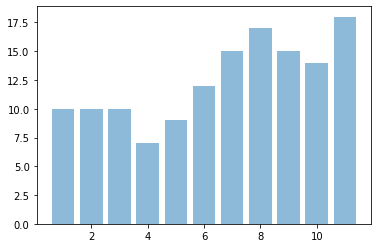

In [78]:
import matplotlib.pyplot as plt

y_pos = np.arange(len(hour))

plt.bar(hour, bikesAvail, align='center', alpha=0.5)

plt.show()

In [79]:
weather = []

for _ in hour:
    weather_pre = mp.predict([[53.35,-6.27,_,1,0,0,0,0,0,0,1,0]])
    weather_pre_round = round(weather_pre[0],2)
    weather.append(weather_pre_round)

print("AM",end=" ")
print(hour)
weather

AM [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


[5.78, 5.68, 6.36, 6.22, 6.85, 6.14, 5.58, 5.9, 6.18, 6.78, 7.18]